<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Transmon-systems-dynamics" data-toc-modified-id="Transmon-systems-dynamics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Transmon systems dynamics</a></span><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Drive" data-toc-modified-id="Drive-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Drive</a></span></li></ul></li></ul></div>

# Transmon systems dynamics

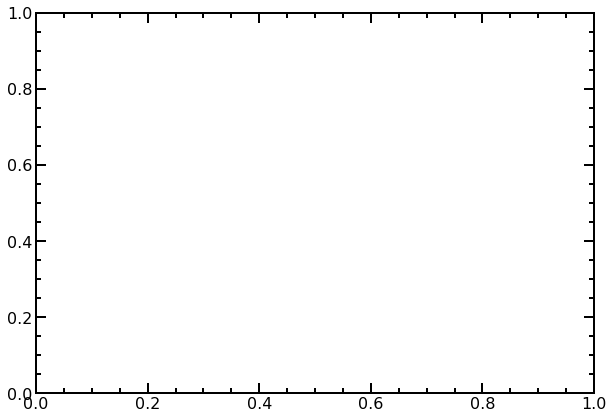

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
from Fluxonium_hamiltonians import qchard_transmon as transmon
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
import plotting_settings
import scipy.linalg

## Parameters 

In [10]:
detuning = 190*1e-3 #GHz
omega1 = 5.23 #GHz
omega2 = 5.29
omega3 = 5.46
omega4 = 5.63
alpha1 = -0.273
alpha2 = -0.273
alpha3 = -0.270
alpha4 = -0.267
nlev = 5

qubit1 = transmon.TransmonSimple(omega_q = omega1, alpha = alpha1, nlev = nlev)
qubit2 = transmon.TransmonSimple(omega_q = omega2, alpha = alpha2, nlev = nlev)
qubit3 = transmon.TransmonSimple(omega_q = omega3, alpha = alpha3, nlev = nlev)
qubit4 = transmon.TransmonSimple(omega_q = omega4, alpha = alpha4, nlev = nlev)
E_int_array = np.linspace(0,0.005,101) #GHz
coupling_type = 'JC-rwa'

In [19]:
print (qubit1.level(3))

14.871


(0.0, 0.1)

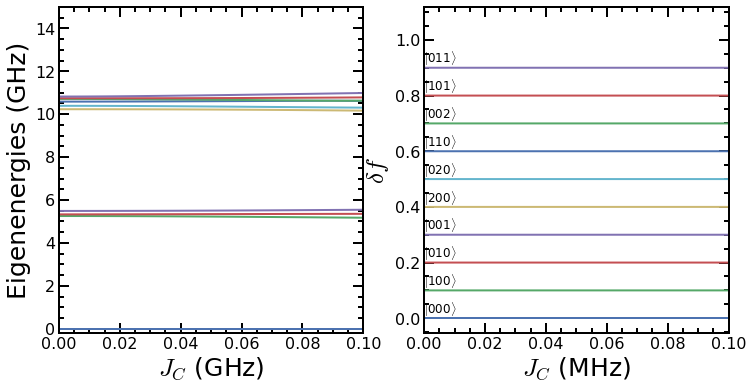

In [12]:
#Sweep the coupling strength, charge
E_int_array = np.linspace(0, 0.1, 101)
energies_coupled_swE = np.zeros((control1.nlev * control2.nlev * target.nlev, len(E_int_array)))
nlev_show = 10

for idx, E_int in enumerate(E_int_array):
    system = coupobj.CoupledObjects(control1, target, control2,
    [control1, target, E_int, coupling_type],
    [control2, target, E_int, coupling_type])
    energies_coupled_swE[:,idx] = system.levels()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = [12,6])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#Transition freqs
for idx in range(0, nlev_show):
    ax1.plot(E_int_array, energies_coupled_swE[idx, :]-energies_coupled_swE[0, :], linewidth = 2.0)
ax1.set_xlabel('$J_C$ (GHz)')
ax1.set_ylabel('Eigenenergies (GHz)')
ax1.set_xlim([E_int_array[0], E_int_array[-1]])
ax1.set_ylim([-0.2,15])

#State labeling
for idx in range(0, nlev_show):
    ax2.plot(E_int_array*1e3, 0.1 * idx+(energies_coupled_swE[idx, :]-energies_coupled_swE[idx, 0]), linewidth = 2.0)
    label = (r'$|$' + system.level_label(idx, label_format='str') + r'$\rangle$')
    ax2.text(0, 0.02 + 0.1 * idx, label, fontsize=12)
ax2.set_xlabel('$J_C$ (MHz)')
ax2.set_ylabel(r'$\delta f$')
ax2.set_xlim([E_int_array[0], E_int_array[-1]])

## Drive

In [14]:
g = 0.005
system = coupobj.CoupledObjects(control1, target,
    [control1, target, g, coupling_type])

#Gate parameters
shape = 'cosflattop'
T_gate = 400 #ns
T_rise = 100
transition_to_drive = ('00','01')
coupl = 10
coupl_const = coupl*1e-3*2*np.pi
delta_omega_d = 0.0

#pulse shape
shape = 'gauss'
sigma = 0.25 #in unit of T_gate
nlev_q = 5

#Drive amplitude and frequency
level1, level2 = transition_to_drive[0], transition_to_drive[1]
omega_d = abs(system.freq(level1, level2)) + delta_omega_d

#Evolve gate
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
H_drive = coupl_const * (system.a(0) + system.a(0).dag() + system.a(1) + system.a(1).dag())
# comp_space = ('000', '100', '010', '001', '110', '011', '101', '111')
U_t = gates.evolution_operator_microwave_nonorm(
        system.H(), H_drive, t_points=t_points, 
        T_gate=T_gate, T_rise = T_rise, shape=shape, sigma=sigma, omega_d=omega_d)